# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import RandomOverSampler


pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

### Import Data

In [3]:
invoice_train = pd.read_csv('data/train/invoice_train.csv')
client_train = pd.read_csv('data/train/client_train.csv')


/var/folders/9x/vhdwn1fd0cldzwf9fnftwf980000gn/T/ipykernel_57067/3220789026.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv('data/train/invoice_train.csv')


In [4]:
print(client_train.shape)
client_train.head()

(135493, 6)


,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00


In [5]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


## EDA


### Drop Outliers

In [6]:
# Drop outliers high month
invoice_train= invoice_train[invoice_train['months_number']<=36]

In [7]:
# Drop invoices where month = 0
invoice_train = invoice_train[invoice_train['months_number']>0]


### Calculate over Columns

In [8]:
# encode counter_type
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)

In [9]:
# calculate consummation per time
# sum all consummation levels and devide by month_number
consommation_sum = (invoice_train['consommation_level_1']+invoice_train['consommation_level_2']+invoice_train['consommation_level_3']+invoice_train['consommation_level_4'])
invoice_train['consommation_per_month'] = consommation_sum/invoice_train['months_number']

In [10]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,20.50
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0,346.00
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,30.75
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0,25.50
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0,47.67


### Merge tables

In [11]:
merged_df = client_train.merge(invoice_train, how= "left", on='client_id')
merged_df.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month
0,60,train_Client_0,11,101,31/12/1994,0.00,2014-03-24,11.00,1335667.00,0,...,1.00,82.00,0.00,0.00,0.00,14302.00,14384.00,4.00,0.00,20.50
1,60,train_Client_0,11,101,31/12/1994,0.00,2013-03-29,11.00,1335667.00,0,...,1.00,1200.00,184.00,0.00,0.00,12294.00,13678.00,4.00,0.00,346.00
2,60,train_Client_0,11,101,31/12/1994,0.00,2015-03-23,11.00,1335667.00,0,...,1.00,123.00,0.00,0.00,0.00,14624.00,14747.00,4.00,0.00,30.75
3,60,train_Client_0,11,101,31/12/1994,0.00,2015-07-13,11.00,1335667.00,0,...,1.00,102.00,0.00,0.00,0.00,14747.00,14849.00,4.00,0.00,25.50
4,60,train_Client_0,11,101,31/12/1994,0.00,2016-11-17,11.00,1335667.00,0,...,1.00,572.00,0.00,0.00,0.00,15066.00,15638.00,12.00,0.00,47.67


In [12]:
merged_df = merged_df.dropna()

In [13]:
merged_df.isnull().sum()

disrict                   0
client_id                 0
client_catg               0
region                    0
creation_date             0
target                    0
invoice_date              0
tarif_type                0
counter_number            0
counter_statue            0
counter_code              0
reading_remarque          0
counter_coefficient       0
consommation_level_1      0
consommation_level_2      0
consommation_level_3      0
consommation_level_4      0
old_index                 0
new_index                 0
months_number             0
counter_type              0
consommation_per_month    0
dtype: int64

<Axes: >

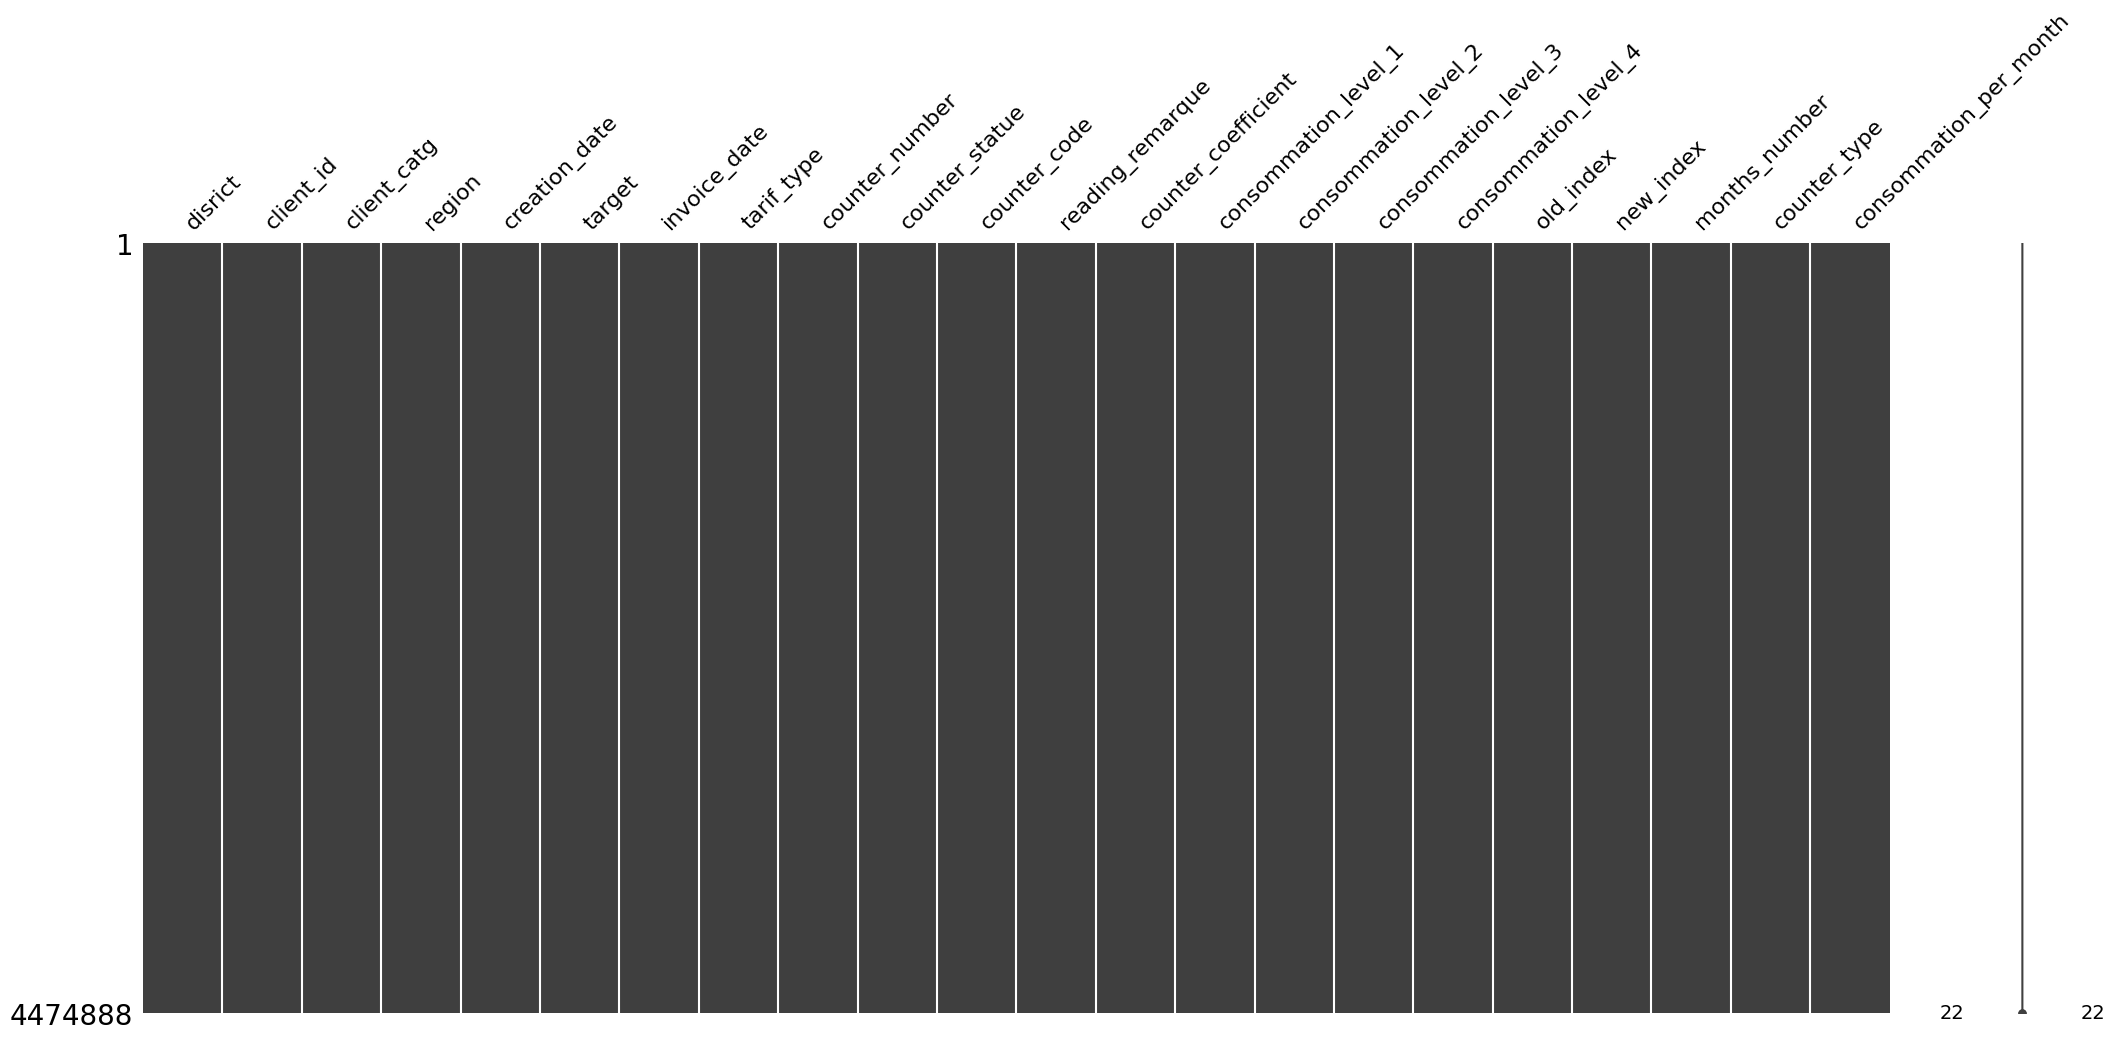

In [14]:
msno.matrix(merged_df)

### Train-Test-Split

In [15]:
y= merged_df['target']
X = merged_df.drop('target', axis = 1)

In [16]:
# test train split only with client-data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)

In [17]:
# remerge the target value because of duplicate lines
X_train['target'] = y_train

In [18]:
X_train.head()

,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month,target
2051277,63,train_Client_33962,11,101,31/12/1994,2011-04-01,11.00,1359643.00,0,203.00,...,759.00,0.00,0.00,0.00,21691.00,22450.00,4.00,0.00,189.75,0.00
1985627,62,train_Client_32174,11,301,02/05/2007,2016-06-10,11.00,6301316.00,0,410.00,...,39.00,0.00,0.00,0.00,87949.00,87988.00,2.00,0.00,19.50,0.00
1501010,69,train_Client_18868,11,107,05/09/2003,2014-05-16,11.00,852854.00,0,203.00,...,717.00,0.00,0.00,0.00,14014.00,14731.00,4.00,0.00,179.25,0.00
2261719,62,train_Client_39728,11,310,28/11/1986,2009-12-25,11.00,605958.00,0,203.00,...,544.00,0.00,0.00,0.00,29500.00,30044.00,4.00,0.00,136.00,0.00
2061076,60,train_Client_34246,11,101,17/10/1988,2017-03-15,11.00,59220.00,0,203.00,...,800.00,162.00,0.00,0.00,18737.00,19699.00,4.00,0.00,240.50,0.00


### Calculate Over Rows

In [19]:
# Transactions Counts - doesn't make sense, because in test-data we only look up 1 row> Transact = 1!
# transaction_counts_df = X_train.groupby('client_id').size().reset_index(name='transactions_count'.format('1'))
# transaction_counts_df
# X_train = X_train.merge(transaction_counts_df, how='left', on='client_id' )
# X_train.sort_values('client_id').head()

In [20]:
# most frequent reading_remarque (Maria)

most_frequ_reading_rem_df = (
    X_train.groupby('client_id')['reading_remarque']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index(name='most_frequ_reading_rem')
)

X_train = X_train.merge(most_frequ_reading_rem_df, how='left', on='client_id')
X_train.sort_values('client_id').head()

,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month,target,most_frequ_reading_rem
1331018,60,train_Client_0,11,101,31/12/1994,2008-07-28,11.00,1335667.00,0,203.00,...,0.00,0.00,0.00,5246.00,5417.00,4.00,0.00,42.75,0.00,6.00
2358241,60,train_Client_0,11,101,31/12/1994,2017-07-17,11.00,1335667.00,0,207.00,...,0.00,0.00,0.00,15638.00,15952.00,8.00,0.00,39.25,0.00,6.00
889910,60,train_Client_0,11,101,31/12/1994,2006-06-23,11.00,1335667.00,0,203.00,...,0.00,0.00,0.00,3950.00,4112.00,4.00,0.00,40.50,0.00,6.00
238672,60,train_Client_0,11,101,31/12/1994,2011-03-30,11.00,1335667.00,0,203.00,...,0.00,0.00,0.00,7273.00,7770.00,4.00,0.00,124.25,0.00,6.00
753205,60,train_Client_0,11,101,31/12/1994,2014-03-24,11.00,1335667.00,0,203.00,...,0.00,0.00,0.00,14302.00,14384.00,4.00,0.00,20.50,0.00,6.00


In [21]:
# mean counter_coefficient (Maria)

# mean counter_coefficient
mean_counter_coeff_df = X_train.groupby('client_id')["counter_coefficient"].mean().reset_index(name='mean_counter_coeff')
# Merge with X_train
X_train = X_train.merge(mean_counter_coeff_df, how='left', on='client_id')
X_train.sort_values('client_id').tail()

,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month,target,most_frequ_reading_rem,mean_counter_coeff
1655274,63,train_Client_99997,11,311,22/11/2011,2013-12-06,40.00,0.00,0,5.00,...,0.00,0.00,311.00,363.00,4.00,1.00,13.00,0.00,9.00,1.00
2702109,63,train_Client_99997,11,311,22/11/2011,2014-02-17,40.00,0.00,0,5.00,...,0.00,0.00,406.00,524.00,4.00,1.00,29.50,0.00,9.00,1.00
1695716,60,train_Client_99998,11,101,22/12/1993,2005-08-19,10.00,1253571.00,0,202.00,...,0.00,0.00,3197.00,3732.00,8.00,0.00,66.88,0.00,9.00,1.00
2026895,60,train_Client_99999,11,101,18/02/1986,1996-09-25,11.00,560948.00,0,203.00,...,0.00,0.00,13884.00,14143.00,4.00,0.00,64.75,0.00,6.00,1.00
1817627,60,train_Client_99999,11,101,18/02/1986,1996-01-25,11.00,560948.00,0,203.00,...,0.00,0.00,12765.00,13281.00,4.00,0.00,129.00,0.00,6.00,1.00


In [22]:
# calculate mean consummation per month for each client
mean_consommation_per_month = X_train.groupby('client_id')['consommation_per_month'].mean().reset_index(name='mean_consommation_per_month')
mean_consommation_per_month
X_train = X_train.merge(mean_consommation_per_month, how='left', on='client_id' )
X_train.sort_values('client_id').head()


,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month,target,most_frequ_reading_rem,mean_counter_coeff,mean_consommation_per_month
1331018,60,train_Client_0,11,101,31/12/1994,2008-07-28,11.00,1335667.00,0,203.00,...,0.00,5246.00,5417.00,4.00,0.00,42.75,0.00,6.00,1.00,85.25
2358241,60,train_Client_0,11,101,31/12/1994,2017-07-17,11.00,1335667.00,0,207.00,...,0.00,15638.00,15952.00,8.00,0.00,39.25,0.00,6.00,1.00,85.25
889910,60,train_Client_0,11,101,31/12/1994,2006-06-23,11.00,1335667.00,0,203.00,...,0.00,3950.00,4112.00,4.00,0.00,40.50,0.00,6.00,1.00,85.25
238672,60,train_Client_0,11,101,31/12/1994,2011-03-30,11.00,1335667.00,0,203.00,...,0.00,7273.00,7770.00,4.00,0.00,124.25,0.00,6.00,1.00,85.25
753205,60,train_Client_0,11,101,31/12/1994,2014-03-24,11.00,1335667.00,0,203.00,...,0.00,14302.00,14384.00,4.00,0.00,20.50,0.00,6.00,1.00,85.25


In [23]:
# mean month_numbers per client (Jesus)
months_per_client = X_train.groupby('client_id')['months_number'].mean().reset_index(name='mean_months')
months_per_client
X_train = X_train.merge(months_per_client, how='left', on='client_id' )
X_train.sort_values('client_id').head()


,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,old_index,new_index,months_number,counter_type,consommation_per_month,target,most_frequ_reading_rem,mean_counter_coeff,mean_consommation_per_month,mean_months
1331018,60,train_Client_0,11,101,31/12/1994,2008-07-28,11.00,1335667.00,0,203.00,...,5246.00,5417.00,4.00,0.00,42.75,0.00,6.00,1.00,85.25,4.58
2358241,60,train_Client_0,11,101,31/12/1994,2017-07-17,11.00,1335667.00,0,207.00,...,15638.00,15952.00,8.00,0.00,39.25,0.00,6.00,1.00,85.25,4.58
889910,60,train_Client_0,11,101,31/12/1994,2006-06-23,11.00,1335667.00,0,203.00,...,3950.00,4112.00,4.00,0.00,40.50,0.00,6.00,1.00,85.25,4.58
238672,60,train_Client_0,11,101,31/12/1994,2011-03-30,11.00,1335667.00,0,203.00,...,7273.00,7770.00,4.00,0.00,124.25,0.00,6.00,1.00,85.25,4.58
753205,60,train_Client_0,11,101,31/12/1994,2014-03-24,11.00,1335667.00,0,203.00,...,14302.00,14384.00,4.00,0.00,20.50,0.00,6.00,1.00,85.25,4.58


In [24]:
# create column for each tarif (GAZ 1/ELEC 0)
dummy_counter_type = pd.get_dummies(
    data=X_train['counter_type'],
    drop_first=False,
)
dummy_counter_type = dummy_counter_type.rename(columns={0.0: 'elec', 1.0 : 'gaz'})



d={True:1,False:0}
X_train['elec']=dummy_counter_type['elec'].map(d)
X_train['gaz']=dummy_counter_type['gaz'].map(d)



In [25]:

sum_elec_gaz =  X_train.groupby('client_id')[['elec', 'gaz']].max().reset_index()
sum_elec_gaz
sum_elec_gaz = sum_elec_gaz.rename(columns={'elec': 'elec_max', 'gaz' : 'gaz_max'})
sum_elec_gaz
X_train= X_train.merge(sum_elec_gaz, how='left', on='client_id')
X_train.head()

,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,consommation_per_month,target,most_frequ_reading_rem,mean_counter_coeff,mean_consommation_per_month,mean_months,elec,gaz,elec_max,gaz_max
0,63,train_Client_33962,11,101,31/12/1994,2011-04-01,11.00,1359643.00,0,203.00,...,189.75,0.00,6.00,1.00,113.27,4.00,1,0,1,1
1,62,train_Client_32174,11,301,02/05/2007,2016-06-10,11.00,6301316.00,0,410.00,...,19.50,0.00,6.00,1.00,8.11,3.40,1,0,1,1
2,69,train_Client_18868,11,107,05/09/2003,2014-05-16,11.00,852854.00,0,203.00,...,179.25,0.00,6.00,1.00,70.77,4.00,1,0,1,1
3,62,train_Client_39728,11,310,28/11/1986,2009-12-25,11.00,605958.00,0,203.00,...,136.00,0.00,6.00,1.00,144.65,4.11,1,0,1,0
4,60,train_Client_34246,11,101,17/10/1988,2017-03-15,11.00,59220.00,0,203.00,...,240.50,0.00,6.00,1.00,120.93,3.96,1,0,1,1


### Aggregate & Drop Duplicates

In [26]:
X_train.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'invoice_date', 'tarif_type', 'counter_number', 'counter_statue',
       'counter_code', 'reading_remarque', 'counter_coefficient',
       'consommation_level_1', 'consommation_level_2', 'consommation_level_3',
       'consommation_level_4', 'old_index', 'new_index', 'months_number',
       'counter_type', 'consommation_per_month', 'target',
       'most_frequ_reading_rem', 'mean_counter_coeff',
       'mean_consommation_per_month', 'mean_months', 'elec', 'gaz', 'elec_max',
       'gaz_max'],
      dtype='object')

In [27]:
# Check how many values, if we could aggregate specific features to one single client
# grouped = invoice_train.groupby('client_id')
# test = grouped['counter_type'].nunique()
# test.unique()
# counter_counts_df = invoice_train.groupby('client_id').size().reset_index(name='transactions_count'.format('1'))


In [28]:
# drop columns we dont aggregate
not_agg_features = ['invoice_date', 'tarif_type', 'creation_date', 'counter_number', 'counter_type', 'counter_coefficient', 'counter_statue', 'counter_code', 'reading_remarque', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'consommation_per_month', 'old_index', 'new_index', 'months_number', 'elec', 'gaz' ]
X_train = X_train.drop(not_agg_features, axis=1)

In [29]:
X_train.sort_values('client_id').head()

,disrict,client_id,client_catg,region,target,most_frequ_reading_rem,mean_counter_coeff,mean_consommation_per_month,mean_months,elec_max,gaz_max
1331018,60,train_Client_0,11,101,0.00,6.00,1.00,85.25,4.58,1,0
2358241,60,train_Client_0,11,101,0.00,6.00,1.00,85.25,4.58,1,0
889910,60,train_Client_0,11,101,0.00,6.00,1.00,85.25,4.58,1,0
238672,60,train_Client_0,11,101,0.00,6.00,1.00,85.25,4.58,1,0
753205,60,train_Client_0,11,101,0.00,6.00,1.00,85.25,4.58,1,0


In [30]:
# delete duplicates
X_train = X_train.drop_duplicates()
X_train.sort_values('client_id').head()

,disrict,client_id,client_catg,region,target,most_frequ_reading_rem,mean_counter_coeff,mean_consommation_per_month,mean_months,elec_max,gaz_max
96680,60,train_Client_0,11,101,0.00,6.00,1.00,85.25,4.58,1,0
490662,69,train_Client_1,11,107,0.00,6.00,1.00,125.33,4.35,1,0
107880,62,train_Client_10,11,301,0.00,6.00,1.00,113.47,6.18,1,0
287205,69,train_Client_100,11,105,0.00,6.00,1.00,0.38,4.12,1,0
613239,62,train_Client_1000,11,303,0.00,9.00,1.00,226.25,3.78,1,0


In [31]:
# check if there is only one value per column for each client
clients = X_train.value_counts('client_id').reset_index(name='count')
clients.sort_values('count', ascending=False)

,client_id,count
0,train_Client_0,1
89304,train_Client_100,1
89302,train_Client_10000,1
89301,train_Client_100000,1
89300,train_Client_100001,1
...,...,...
44641,train_Client_99998,1
44640,train_Client_99971,1
44639,train_Client_99882,1
44638,train_Client_99970,1


In [32]:
#clients where month = 0
# train_Client_79075
# train_Client_86638

client = invoice_train[invoice_train['client_id'] == 'train_Client_86638']
client


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month
3985915,train_Client_86638,2016-05-04,40,128190,0,5,8,1,221,0,0,0,2799,3020,4,1,55.25
3985916,train_Client_86638,2016-05-08,11,95113,0,203,9,1,546,0,0,0,49263,49809,4,0,136.50
3985917,train_Client_86638,2017-04-04,11,95113,0,203,9,1,440,0,0,0,50363,50803,4,0,110.00
3985918,train_Client_86638,2016-05-12,11,95113,0,203,9,1,554,0,0,0,49809,50363,4,0,138.50
3985919,train_Client_86638,2016-05-08,40,128190,0,5,8,1,167,0,0,0,3020,3187,4,1,41.75
3985920,train_Client_86638,2016-05-04,11,95113,0,203,9,1,522,0,0,0,48741,49263,4,0,130.50
3985921,train_Client_86638,2017-06-12,11,95113,0,203,9,1,563,0,0,0,51349,51912,4,0,140.75
3985922,train_Client_86638,2017-04-04,40,128190,0,5,8,1,189,0,0,0,3320,3509,4,1,47.25
3985923,train_Client_86638,2015-07-04,40,128190,0,5,8,1,70,0,0,0,2226,2296,4,1,17.50
3985924,train_Client_86638,2017-06-12,40,128190,0,5,9,1,104,0,0,0,3611,3715,4,1,26.00


In [33]:
client = X_train[X_train['mean_consommation_per_month'].isnull()]
client

,disrict,client_id,client_catg,region,target,most_frequ_reading_rem,mean_counter_coeff,mean_consommation_per_month,mean_months,elec_max,gaz_max


In [34]:
X_train.isnull().sum()

disrict                        0
client_id                      0
client_catg                    0
region                         0
target                         0
most_frequ_reading_rem         0
mean_counter_coeff             0
mean_consommation_per_month    0
mean_months                    0
elec_max                       0
gaz_max                        0
dtype: int64

In [35]:
# clean up columns for modeling

X_train = X_train.rename(columns={'disrict': 'district', 'most_frequ_reading_rem' : 'reading_remarque', 'mean_counter_coeff':'counter_coeff', 'mean_consommation_per_month': 'consommation_per_month', 'mean_months': 'months_number', 'elec_max': 'elec', 'gaz_max': 'gaz'})


In [36]:
X_train.head(2)

,district,client_id,client_catg,region,target,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz
0,63,train_Client_33962,11,101,0.00,6.00,1.00,113.27,4.00,1,1
1,62,train_Client_32174,11,301,0.00,6.00,1.00,8.11,3.40,1,1


In [37]:
X_train.to_csv('data/cleaned/train.csv', index=False)

### transform calculations to test set

1. calculate columns


In [38]:
X_test.head()

,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month
1833373,69,train_Client_28061,11,104,29/05/1985,2012-11-22,11.00,490389.00,0,203.00,...,1.00,208.00,0.00,0.00,0.00,18048.00,18256.00,4.00,0.00,52.00
3402073,62,train_Client_70890,11,301,05/10/1982,2010-05-05,11.00,249776.00,0,203.00,...,1.00,471.00,0.00,0.00,0.00,28542.00,29013.00,4.00,0.00,117.75
3639418,63,train_Client_77349,11,312,27/10/1989,2014-11-26,10.00,832726.00,0,202.00,...,1.00,303.00,0.00,0.00,0.00,29210.00,29513.00,4.00,0.00,75.75
1290238,60,train_Client_135077,11,101,27/09/1995,2017-12-01,40.00,2119641.00,0,5.00,...,1.00,303.00,0.00,0.00,0.00,5715.00,6018.00,2.00,1.00,151.50
4207260,60,train_Client_92721,11,101,08/12/2010,2016-03-06,11.00,554124.00,0,433.00,...,1.00,1600.00,800.00,1600.00,1401.00,35205.00,40606.00,8.00,0.00,675.12


In [39]:
# small size of X_test to experimenting
# X_test_small = X_test.iloc[0:10, : ].copy()
# new_months = [0, 4, 0, 4, 8, 0, 4, 0 ,4,3]
# X_test_small['months_number'] = new_months
# X_test_small


In [40]:
# calculate consummation per time
# sum all consummation levels and devide by month_number

def calc_consommation_per_month(x):
    consommation_sum = (x['consommation_level_1']+x['consommation_level_2']+x['consommation_level_3']+x['consommation_level_4'])
    if (x['months_number'] == 0):
        return np.nan
    else:
        return consommation_sum/x['months_number']

X_test['consommation_per_month'] = X_test.apply(calc_consommation_per_month, axis=1)


X_test.head()

,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_per_month
1833373,69,train_Client_28061,11,104,29/05/1985,2012-11-22,11.00,490389.00,0,203.00,...,1.00,208.00,0.00,0.00,0.00,18048.00,18256.00,4.00,0.00,52.00
3402073,62,train_Client_70890,11,301,05/10/1982,2010-05-05,11.00,249776.00,0,203.00,...,1.00,471.00,0.00,0.00,0.00,28542.00,29013.00,4.00,0.00,117.75
3639418,63,train_Client_77349,11,312,27/10/1989,2014-11-26,10.00,832726.00,0,202.00,...,1.00,303.00,0.00,0.00,0.00,29210.00,29513.00,4.00,0.00,75.75
1290238,60,train_Client_135077,11,101,27/09/1995,2017-12-01,40.00,2119641.00,0,5.00,...,1.00,303.00,0.00,0.00,0.00,5715.00,6018.00,2.00,1.00,151.50
4207260,60,train_Client_92721,11,101,08/12/2010,2016-03-06,11.00,554124.00,0,433.00,...,1.00,1600.00,800.00,1600.00,1401.00,35205.00,40606.00,8.00,0.00,675.12


In [41]:

# column counter_type becomes gaz
X_test = X_test.rename(columns={'counter_type': 'gaz'})
X_test['gaz'] = X_test['gaz'].astype(int)
# create elec-column, inverted gaz
X_test['elec'] = (~X_test['gaz'].astype(bool)).astype(int)

X_test[['gaz', 'elec']]

X_test.head()

,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,...,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,gaz,consommation_per_month,elec
1833373,69,train_Client_28061,11,104,29/05/1985,2012-11-22,11.00,490389.00,0,203.00,...,208.00,0.00,0.00,0.00,18048.00,18256.00,4.00,0,52.00,1
3402073,62,train_Client_70890,11,301,05/10/1982,2010-05-05,11.00,249776.00,0,203.00,...,471.00,0.00,0.00,0.00,28542.00,29013.00,4.00,0,117.75,1
3639418,63,train_Client_77349,11,312,27/10/1989,2014-11-26,10.00,832726.00,0,202.00,...,303.00,0.00,0.00,0.00,29210.00,29513.00,4.00,0,75.75,1
1290238,60,train_Client_135077,11,101,27/09/1995,2017-12-01,40.00,2119641.00,0,5.00,...,303.00,0.00,0.00,0.00,5715.00,6018.00,2.00,1,151.50,0
4207260,60,train_Client_92721,11,101,08/12/2010,2016-03-06,11.00,554124.00,0,433.00,...,1600.00,800.00,1600.00,1401.00,35205.00,40606.00,8.00,0,675.12,1


2. Drop unimportend columns

In [42]:
X_train.columns

Index(['district', 'client_id', 'client_catg', 'region', 'target',
       'reading_remarque', 'counter_coeff', 'consommation_per_month',
       'months_number', 'elec', 'gaz'],
      dtype='object')

In [43]:
# drop column
not_agg_features = ['client_id' , 'creation_date', 'invoice_date', 'tarif_type', 'counter_number','counter_statue', 'counter_code', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'old_index', 'new_index' ]
X_test = X_test.drop(not_agg_features, axis=1)



In [44]:
X_test['target'] = y_test

In [45]:
X_test.head()

,disrict,client_catg,region,reading_remarque,counter_coefficient,months_number,gaz,consommation_per_month,elec,target
1833373,69,11,104,8.00,1.00,4.00,0,52.00,1,0.00
3402073,62,11,301,6.00,1.00,4.00,0,117.75,1,0.00
3639418,63,11,312,9.00,1.00,4.00,0,75.75,1,1.00
1290238,60,11,101,9.00,1.00,2.00,1,151.50,0,0.00
4207260,60,11,101,8.00,1.00,8.00,0,675.12,1,0.00


In [46]:
X_train.head(2)

,district,client_id,client_catg,region,target,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz
0,63,train_Client_33962,11,101,0.00,6.00,1.00,113.27,4.00,1,1
1,62,train_Client_32174,11,301,0.00,6.00,1.00,8.11,3.40,1,1


In [47]:
# reorder and cleanup data for modelling
X_test = X_test.rename(columns={'disrict': 'district', 'counter_coefficient': 'counter_coeff'})
X_test = X_test.loc[:, ['district','client_catg', 'region', 'reading_remarque', 'counter_coeff', 'consommation_per_month', 'months_number', 'elec', 'gaz', 'target']]

In [48]:
X_test.head(2)

,district,client_catg,region,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz,target
1833373,69,11,104,8.00,1.00,52.00,4.00,1,0,0.00
3402073,62,11,301,6.00,1.00,117.75,4.00,1,0,0.00


In [49]:
X_test.to_csv('data/cleaned/test.csv', index=False)
